<table style="width :100%;">
    <td style="width : 7.5%;">
        <img style="float: left;
                width: 75px;"
         src="https://upload.wikimedia.org/wikipedia/fr/d/d9/Logo_T%C3%A9l%C3%A9com_ParisTech.svg" />
    </td>
    <td style="width : 15%;">
        TELECOM PARIS<br />2021/2022<br /><br /> IA702<br />Mr Elie AZERAF
    </td>
    <td>
        <h1><center>PROBABILISTIC MODELS & MACHINE LEARNING<br /><br />TP2 : La Segmentation d'image</center></h1>
    </td>
    <td style="width : 12.5%;">
        Victor LEDEZ <br />Date TP : 2021/10/06<br /><br /> Date CR : 2021/10/24<br /> Version : 1
    </td>
</table>    

<hr>

## 1. La segmentation bayésienne d'image

<hr>

#### Modules Imports

In [1]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
import scipy.stats as stats
from math import log2, sqrt
import pandas as pd
import numpy as np
import math

!pip install opencv-python
import cv2 as cv


#### Main Variables

In [2]:
P1_INITIAL = 0.4
P2_INITIAL = 1 - P1_INITIAL

MU1_INITIAL = 0
SIGMA1_INITIAL = 150

MU2_INITIAL = 255
SIGMA2_INITIAL = 150

ITERATIONS = 100

#### Utils Functions

In [3]:
def get_line_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction ne fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    """
    return [a.flatten() for a in np.indices((dSize, dSize))]


def line_transform_img(img):
    """
    Cette fonction prend une image carrée en entrée, et retourne l'image applatie (1 dimension) selon le parcours ligne par ligne
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    idx = get_line_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_line_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours ligne par ligne
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_line_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img


def get_peano_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
    selon la courbe de Hilbert-Peano
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours de Hilbert-Peano
    """
    assert log2(dSize).is_integer(), 'veuillez donne une dimension étant une puissance de 2'
    xTmp = 0
    yTmp = 0
    dirTmp = 0
    dirLookup = np.array(
        [[3, 0, 0, 1], [0, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 0], [1, 0, 0, 3], [2, 1, 1, 0], [3, 2, 2, 1],
         [0, 3, 3, 2]]).T
    dirLookup = dirLookup + np.array(
        [[4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [0, 4, 4, 0], [0, 4, 4, 0], [0, 4, 4, 0],
         [0, 4, 4, 0]]).T
    orderLookup = np.array(
        [[0, 2, 3, 1], [1, 0, 2, 3], [3, 1, 0, 2], [2, 3, 1, 0], [1, 3, 2, 0], [3, 2, 0, 1], [2, 0, 1, 3],
         [0, 1, 3, 2]]).T
    offsetLookup = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
    for i in range(int(log2(dSize))):
        xTmp = np.array([(xTmp - 1) * 2 + offsetLookup[0, orderLookup[0, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[1, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[2, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[3, dirTmp]] + 1])

        yTmp = np.array([(yTmp - 1) * 2 + offsetLookup[1, orderLookup[0, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[1, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[2, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[3, dirTmp]] + 1])

        dirTmp = np.array([dirLookup[0, dirTmp], dirLookup[1, dirTmp], dirLookup[2, dirTmp], dirLookup[3, dirTmp]])

        xTmp = xTmp.T.flatten()
        yTmp = yTmp.T.flatten()
        dirTmp = dirTmp.flatten()

    x = - xTmp
    y = - yTmp
    return x, y


def peano_transform_img(img):
    """
    Cette fonction prend une image carrée (dont la dimension est une puissance de 2) en entrée,
    et retourne l'image applatie (1 dimension) selon le parcours de Hilbert-Peano
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    assert log2(img.shape[0]).is_integer(), 'veuillez donne rune image dont la dimension est une puissance de 2'
    idx = get_peano_index(img.shape[0])
    return img[idx[0], idx[1]]


def transform_peano_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours de Hilbert-Peano
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_peano_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img


def bruit_gauss2(X, cl1, cl2, m1, sig1, m2, sig2):
    return (X == cl1) * np.random.normal(m1, sig1, X.shape) + (X == cl2) * np.random.normal(m2, sig2, X.shape)


def MAP_MPM2(Y, cl1, cl2, p1, p2, m1, sig1, m2, sig2):
    return np.where((p1*norm.pdf(Y, m1, sig1)) > (p2*norm.pdf(Y, m2, sig2)), cl1, cl2)


def calc_probaprio2(X, cl1, cl2):
    return np.sum(X==cl1)/X.size, np.sum(X==cl2)/X.size


def taux_erreur(A, B):
    return np.count_nonzero(A!=B)/A.size

<hr>

## 2. Modèle des couples indépendants

<hr>

### <ins>Question 3 :</ins>
> Ecrire la fonction estim_param_EM_indep(iter, Y, p1, p2, m1, sig1, m2, sig2), qui estime les paramètres p1, p2, m1, sig1, m2, sig2 par l’algorithme EM, à partir des observations Y.

#### Functions

In [4]:
def load_image_1d(path):
    return line_transform_img(cv.cvtColor(cv.imread('./images/' + str(path) + '.bmp'), cv.COLOR_BGR2GRAY))

In [5]:
def classes_calculations(input):
    """calculates the classes for a given input

    Args:
        input ([Number]): the input signal

    Returns:
        (Number): the two classes
    """
    counts, _ = np.histogram(input, bins=int(input.max() + 1), range=(0, int(input.max())))
    return np.nonzero(counts)[0]

In [6]:
def estim_param_EM_indep(iterations, Y, p1_initial, m1_initial, sig1_initial, p2_initial, m2_initial, sig2_initial):

    for i in range(iterations):

        a = p1_initial * stats.norm.pdf(Y, m1_initial, sig1_initial)
        b = p2_initial * stats.norm.pdf(Y, m2_initial, sig2_initial)

        p1_new = a / (a+b)
        p2_new = b / (a+b)

        p1 = np.mean(p1_new)
        p2 = 1 - p1

        m1 = np.sum(Y*p1_new) / np.sum(p1_new)
        m2 = np.sum(Y*p2_new) / np.sum(p2_new)

        sig1 = np.sqrt(np.sum(((Y-m1)**2)*p1_new) / np.sum(p1_new))
        sig2 = np.sqrt(np.sum(((Y-m2)**2)*p2_new) / np.sum(p2_new))

    return p1, m1, sig1, p2, m2, sig2

#### Answer

Dans un premier temps, nous chargons une image, nous l'affichons et nous la converstissons en une array une dimension.

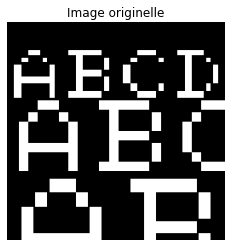

In [7]:
image_name = 'alfa2'

path = f'images/{image_name}.bmp'
image = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
plt.title('Image originelle')
plt.axis('off')
plt.imshow(image, cmap='gray')

X = load_image_1d(image_name)


Maintenant, nous pouvons estimer les classes pour bruiter l'image.

In [8]:
class1, class2 = classes_calculations(X)

print(f'classe 1 : {class1}')
print(f'classe 2 : {class2}')

Y = bruit_gauss2(X, class1, class2, MU1_INITIAL, SIGMA1_INITIAL, MU2_INITIAL, SIGMA2_INITIAL)

classe 1 : 0
classe 2 : 255


Voici l'image une fois qu'elle a été bruité :

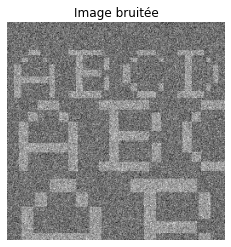

In [9]:
plt.title('Image bruitée')
plt.axis('off')
plt.imshow(transform_line_in_img(Y, 256), cmap='gray')


Ensuite, nous pouvons predire les valeurs de p1, p2, m1, m2, sigma1 et sigma2.

In [10]:

p1_predicted, m1_predicted, sig1_predicted, p2_predicted, m2_predicted, sig2_predicted = estim_param_EM_indep(ITERATIONS, Y, P1_INITIAL, MU1_INITIAL, SIGMA1_INITIAL, P2_INITIAL, MU2_INITIAL, SIGMA2_INITIAL)


In [11]:

print(f'p1_predicted is: {p1_predicted:.3f}')
print(f'm1_predicted is: {m1_predicted:.3f}')
print(f'sig1_predicted is: {sig1_predicted:.3f} \n')

print(f'p2_predicted is: {p2_predicted:.3f}')
print(f'm2_predicted is: {m2_predicted:.3f}')
print(f'sig2_predicted is: {sig2_predicted:.3f}')


p1_predicted is: 0.558
m1_predicted is: -40.986
sig1_predicted is: 137.485 

p2_predicted is: 0.442
m2_predicted is: 192.777
sig2_predicted is: 154.636


### <ins>Question 4 :</ins>
> Ecrire le script Segmentation_image_indep.py qui acquiert, bruite, estime les paramètres sur la version bruitée puis segmente une image (carré dont la longueur du côté est une puissance de 2) à deux classes selon le modèle indépendant. Ensuite le script calculera le taux d’erreur entre l’image segmentée et l’image réelle et enfin affichera l’image bruitée, l’image segmentée et l’image réelle.

> Pour initialiser l’estimation des paramètres, on utilisera l’algorithme du kmeans (kmeans = KMeans(n_clusters=2, random_state=0).fit(Y) et kmeans.labels_) du package scikit-learn, on pourra aussi utiliser la fonction calc_probaprio2 pour calculer les probabilités initiales sur le signal segmenté par le kmeans.

> Pour charger une image noir et blanc, on utilisera la fonction cv.cvtColor(cv.imread('path_to_image'), cv.COLOR_BGR2GRAY) et la fonction line_transform_img(img) du script utils.py pour transformer notre image en deux dimension, en signal 
une dimension.

> Pour retransformer votre signal une dimension en image, on pourra utiliser la fonction transform_line_in_img(signal, dSize)et pour afficher une image on pourra utiliser cv.imshow(title, img).


#### Functions

In [12]:
def segmentation_image_indep(image_name, m1, sig1, m2, sig2):
    print(f'-----------\n Traitement {image_name} | m1 : {m1}, sig1 : {sig1} ; m2 : {m2}, sig2 : {sig2}')

    # ! Charge et bruite le signal d'entrée
    X = load_image_1d(image_name)

    class1, class2 = classes_calculations(X)

    Y = bruit_gauss2(X, class1, class2, m1, sig1, m2, sig2)

    # ! Calcule les parametres initiaux
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1, 1))

    class1_K, class2_K = classes_calculations(kmeans.labels_)

    p1_initial, p2_initial = calc_probaprio2(kmeans.labels_, class1_K, class2_K)

    m1_initial = Y[np.where(kmeans.labels_ == class1_K)].mean()
    m2_initial = Y[np.where(kmeans.labels_ == class2_K)].mean()

    sig1_initial = Y[np.where(kmeans.labels_ == class1_K)].std()
    sig2_initial = Y[np.where(kmeans.labels_ == class2_K)].std()

    # ! Estime les nouveaux parametres
    p1_K, p2_K, m1_K, sig1_K, m2_K, sig2_K = estim_param_EM_indep(ITERATIONS, Y, p1_initial, p2_initial, m1_initial, sig1_initial, m2_initial, sig2_initial)

    S = MAP_MPM2(Y, class1, class2, p1_K, p2_K, m1_K, sig1_K, m2_K, sig2_K)
    S_inverse = (S == class1) * class2

    X_image = transform_line_in_img(X, int(math.sqrt(len(X))))
    Y_image = transform_line_in_img(Y, int(math.sqrt(len(Y))))

    if taux_erreur(X, S) > taux_erreur(X, S_inverse):
        S = S_inverse
    S_image = transform_line_in_img(S, int(math.sqrt(len(S))))

    # ! Affiche les images
    plt.figure(figsize=(10, 7))

    plt.subplot(1, 3, 1)
    plt.title('Image originelle')
    plt.axis('off')
    plt.imshow(X_image, cmap='gray', vmin=class1, vmax=class2)

    plt.subplot(1, 3, 2)
    plt.title('Image bruitée')
    plt.axis('off')
    plt.imshow(Y_image, cmap='gray', vmin=np.min(Y_image), vmax=np.max(Y_image))

    plt.subplot(1, 3, 3)
    plt.title('Image segmentée')
    plt.axis('off')
    plt.imshow(S_image, cmap='gray', vmin=class1, vmax=class2)

    plt.show(block=True)
    plt.pause(3)
    plt.close()

    tau = taux_erreur(X, S)

    print(f'Taux d\'erreur : {tau:.3f} soit {round(tau * 100, 0):.0f}%')

    return tau

#### Answer

-----------
 Traitement alfa2 | m1 : 0, sig1 : 150 ; m2 : 255, sig2 : 150


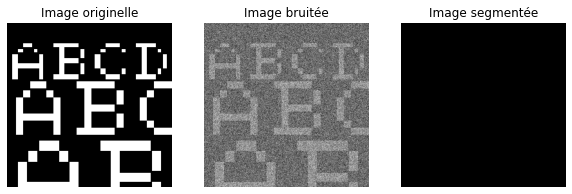

Taux d'erreur : 0.247 soit 25%


In [13]:
tau = segmentation_image_indep(image_name, MU1_INITIAL, SIGMA1_INITIAL, MU2_INITIAL, SIGMA2_INITIAL)

### <ins>Question 5 :</ins>
> Tester la méthode pour 3 images bien choisies dans le dossier, avec les 3 bruits du tableau ci-dessous. Présenter les résultats (taux d’erreur et images segmentées) et commenter. Pour le choix des images, choisir une image parmi (alpha2, beee2 et cible2), une image parmi (country2, promenade2 et veau2) et une image parmi (zebre2 et city2).

In [14]:
images = [
    'cible2',
    'veau2',
    'city2'
]

m1s = [0, 1, 0]
m2s = [3, 1, 1] 
sig1s = [1, 1, 1] 
sig2s = [2, 5, 1] 


-----------
 Traitement cible2 | m1 : 0, sig1 : 1 ; m2 : 3, sig2 : 2


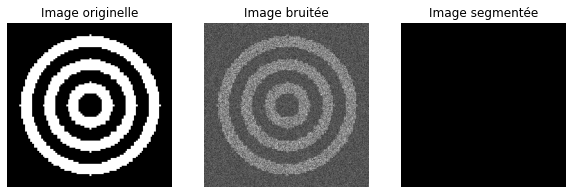

Taux d'erreur : 0.305 soit 31%
-----------
 Traitement cible2 | m1 : 1, sig1 : 1 ; m2 : 1, sig2 : 5


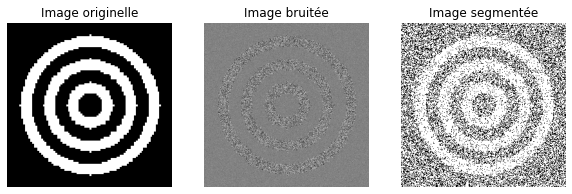

Taux d'erreur : 0.461 soit 46%
-----------
 Traitement cible2 | m1 : 0, sig1 : 1 ; m2 : 1, sig2 : 1


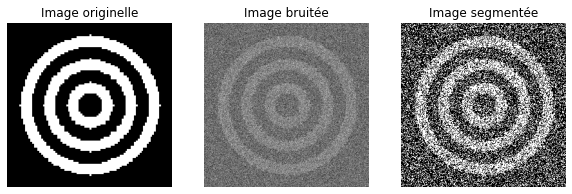

Taux d'erreur : 0.310 soit 31%
-----------
 Traitement veau2 | m1 : 0, sig1 : 1 ; m2 : 3, sig2 : 2


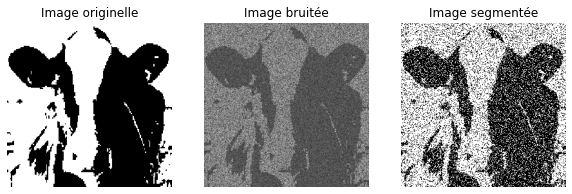

Taux d'erreur : 0.199 soit 20%
-----------
 Traitement veau2 | m1 : 1, sig1 : 1 ; m2 : 1, sig2 : 5


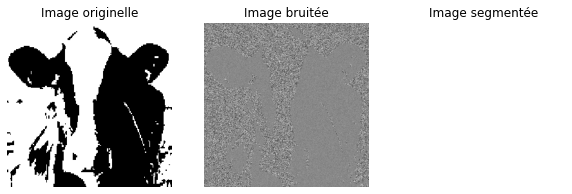

Taux d'erreur : 0.472 soit 47%
-----------
 Traitement veau2 | m1 : 0, sig1 : 1 ; m2 : 1, sig2 : 1


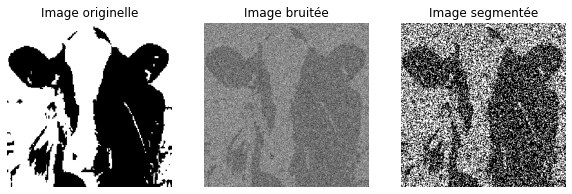

Taux d'erreur : 0.330 soit 33%
-----------
 Traitement city2 | m1 : 0, sig1 : 1 ; m2 : 3, sig2 : 2


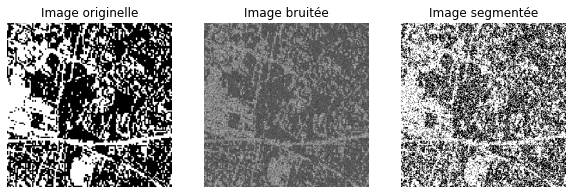

Taux d'erreur : 0.249 soit 25%
-----------
 Traitement city2 | m1 : 1, sig1 : 1 ; m2 : 1, sig2 : 5


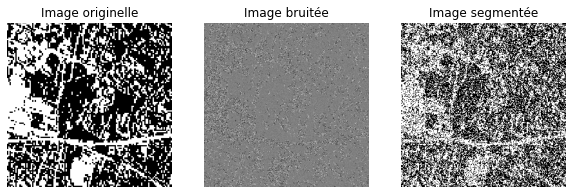

Taux d'erreur : 0.258 soit 26%
-----------
 Traitement city2 | m1 : 0, sig1 : 1 ; m2 : 1, sig2 : 1


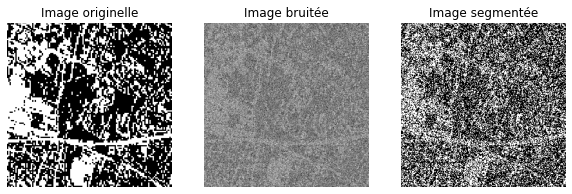

Taux d'erreur : 0.308 soit 31%


In [15]:
for image in images:
    for i in range(0, 3):
        segmentation_image_indep(image, m1s[i], sig1s[i], m2s[i], sig2s[i])

Nous arrivons a la meme conclusion que lors du TP precedant, plus les densités de probabilités associées aux bruits se recouvrent, plus la reconstitution sera fausse. Nous constatons bien ce phénoméne sur les images ci-dessus.

Cependant, pour ce qu'il s'agit de city2, la reconstitution est de moins bonne qualité puisque l'image est assez homogenes, comparé au veau par example, ce qui provoque plus d'erreurs.

<hr>

## 3. Modèle de chaîne de Markov cachées

<hr>

### <ins>Question 1 :</ins>
> Commencer par construire une matrice Mat_f destinée à simplifier les calculs des probabilités forward et backward. Ecrire pour cela la fonction Mat_f = gauss2(Y,n,m1,sig1,m2,sig2) qui construit la matrice de dimension n*2 contenant les transformations du processus bruité Y par les densitées du bruit correspondant à chaque classe.

In [16]:
image_name = 'city2'

path = f'images/{image_name}.bmp'
image = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)

X = peano_transform_img(image)

class1, class2 = classes_calculations(X)

m1 = 0
sig1 = 1
m2 = 3
sig2 = 5

Y = bruit_gauss2(X, class1, class2, m1, sig1, m2, sig2)


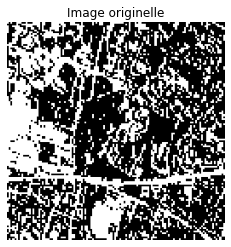

In [17]:
plt.title('Image originelle')
plt.axis('off')
plt.imshow(image, cmap='gray')

#### Functions

In [18]:
def gauss2(Y, m1, sig1, m2, sig2):
    mat_f = np.zeros((2, len(Y)))
    mat_f[0, :] = norm.pdf(Y, m1, sig1)
    mat_f[1, :] = norm.pdf(Y, m2, sig2)
    return mat_f

#### Answer

In [19]:
Y2 = gauss2(Y, m1, sig1, m2, sig2)

Text(0.5, 1.0, 'Signal bruité transformé par m2/sig2')

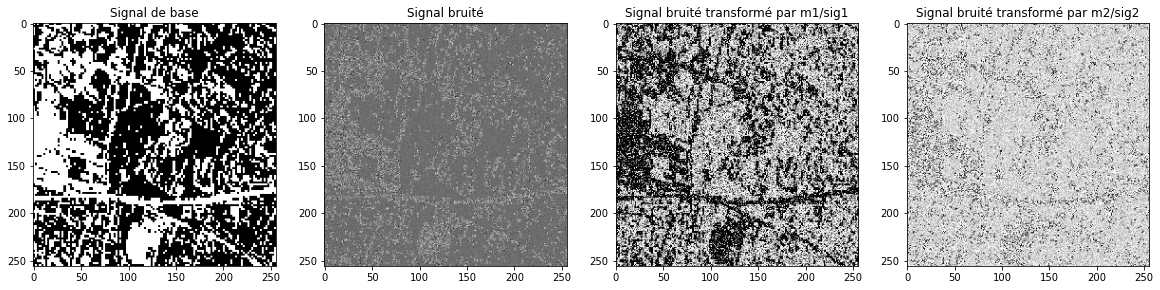

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7))

ax[0].imshow(transform_peano_in_img(X, 256), cmap='gray')
ax[0].set_title("Signal de base")

ax[1].imshow(transform_peano_in_img(Y, 256), cmap='gray')
ax[1].set_title("Signal bruité")

ax[2].imshow(transform_peano_in_img(Y2[0], 256), cmap='gray')
ax[2].set_title("Signal bruité transformé par m1/sig1")

ax[3].imshow(transform_peano_in_img(Y2[1], 256), cmap='gray')
ax[3].set_title("Signal bruité transformé par m2/sig2")

### <ins>Question 2 :</ins>
> Ecrire la fonction alfa = forward2(Mat_f,A,p10,p20) qui calcule récursivement les composantes de la matrice alfa de dimension n*2 par la procédure forward. A est la matrice de transition. Attention, les images donnant des chaînes de Markov très longues, il faudra utiliser la version rescalée de l’algorithme.

In [21]:
# Initialisation aléatoire de p10, p20 et A pour tester les fonctions qu'on définit
p10, p20 = 0.4, 0.6
A = np.matrix('0.2 0.8;0.6 0.4')


In [22]:
def forward2(Mat_f, A, p10, p20):
    n = Mat_f.shape[1]
    alpha = np.zeros(shape=(2, n))

    alpha[0, 0] = p10 * Mat_f[0, 0]
    alpha[1, 0] = p20 * Mat_f[1, 0]

    S = alpha[0, 0] + alpha[1, 0]
    alpha[0, 0] /= S
    alpha[1, 0] /= S

    for i in range(1, n):
        alpha[0, i] = ((alpha[0, i-1] * A[0, 0]) +
                       (alpha[1, i-1] * A[1, 0])) * Mat_f[0, i]
        alpha[1, i] = ((alpha[0, i-1] * A[0, 1]) +
                       (alpha[1, i-1] * A[1, 1])) * Mat_f[1, i]

        S = alpha[0, i] + alpha[1, i]
        alpha[0, i] /= S
        alpha[1, i] /= S

    return alpha


In [23]:
alpha = forward2(Y2, A, p10, p20)

print(f'alpha : {alpha}')

alpha : [[7.90597398e-01 1.42903104e-04 8.13552124e-01 ... 7.01423261e-01
  4.66205876e-01 1.08938208e-01]
 [2.09402602e-01 9.99857097e-01 1.86447876e-01 ... 2.98576739e-01
  5.33794124e-01 8.91061792e-01]]


### <ins>Question 3 :</ins>
>  Ecrire la fonction beta = backward2(Mat_f,A) qui calcule récursivement les composantes de la matrice beta de dimension nx2 par la procédure backward. Attention, les images donnant des chaînes de Markov très longues, il faudra utiliser la version rescalée de l’algorithme.

In [24]:
def backward2(Mat_f, A):

    n = Mat_f.shape[1]
    beta = np.zeros(shape=(2, n))

    beta[0, -1] = 1/2
    beta[1, -1] = 1/2

    for i in range(n-1, 0, -1):
        beta[0, i-1] = (beta[0, i] * A[0, 0] * Mat_f[0, i]) + \
            (beta[1, i] * A[0, 1] * Mat_f[1, i])
        beta[1, i-1] = (beta[0, i] * A[1, 0] * Mat_f[0, i]) + \
            (beta[1, i] * A[1, 1] * Mat_f[1, i])

        S = beta[0, i-1] + beta[1, i-1]

        beta[0, i-1] /= S
        beta[1, i-1] /= S

    return beta


In [25]:
beta = backward2(Y2, A)

print(f'beta : {beta}')

beta : [[0.66660993 0.36154741 0.5850858  ... 0.38641924 0.6234925  0.5       ]
 [0.33339007 0.63845259 0.4149142  ... 0.61358076 0.3765075  0.5       ]]


### <ins>Question 4 :</ins>
> Ecrire la fonction X_apost = MPM_chaines2(Mat_f,n,cl1,cl2,A,p10,p20) qui segmente le signal en suivant le critère du MPM pour les chaînes de Markov cachées.

Formule a utiliser :

$$ p(X = \omega_i / y ; \theta)= \frac{{\alpha(\omega_i)}.{\beta(\omega_i)}}{\sum_{\omega_i}{\alpha(\omega_i)}.{\beta(\omega_i)}} = \gamma(X = \omega_i)$$

#### Functions

In [26]:
def Ksi(alpha, beta):
    ksi = alpha * beta
    ksi = ksi / np.sum(ksi, axis=0)
    return ksi


In [27]:
def MPM_chaines2(Mat_f, cl1, cl2, A, p10, p20):

    alpha = forward2(Mat_f, A, p10, p20)
    beta = backward2(Mat_f, A)
    ksi = Ksi(alpha, beta)
    X_apost = np.where(ksi[0, :] >= ksi[1, :], cl1, cl2)

    return X_apost

#### Answer

In [28]:
X_apost = MPM_chaines2(Y2, class1, class2, A, p10, p20)

X_apost

array([  0, 255,   0, ...,   0,   0, 255], dtype=int64)

### <ins>Question 5 :</ins>
> Ecrire la fonction calc_probaprio_mc(X, cl1,cl2) qui estime, grâce aux estimateurs empiriques des fréquences, les probabilités d’apparitions de chacune des classes et les probabilités de transition de la chaine de Markov à partir du signal d'origine X et renvoie le vecteur de probabilité p et la matrice de transition A.

In [29]:
def calc_probaprio_mc(X, cl1, cl2):

    p = [(X == cl1).mean(), (X == cl2).mean()]

    A = np.array(pd.crosstab(X[:-1], X[1:], normalize=1).T)

    return p, A


In [30]:
p, A = calc_probaprio_mc(X, class1, class2)

p, A

([0.5919952392578125, 0.4080047607421875],
 array([[0.88671805, 0.11328195],
        [0.1643354 , 0.8356646 ]]))

### <ins>Question 6 :</ins>
> Ecrire la fonction estim_param_EM_mc(iter, Y, A, p10, p20, m1, sig1, m2, sig2), qui estime les paramètres A, p10, p20, m1, sig1, m2, sig2 par l’algorithme EM, à partir des observations Y.


In [31]:
def Psi(Y2, A, alpha, beta):

    af = A.flatten()
    a2 = np.vstack((alpha[0], alpha[0], alpha[1], alpha[1])).T
    b2 = np.hstack((beta.T, beta.T))
    y2 = np.hstack((Y2.T, Y2.T))
    ps2 = a2[:-1, :] * af * y2[1:, :] * b2[1:, :]
    psi = (ps2 / np.sum(ps2, axis=1).reshape(-1, 1)).T

    return psi


In [32]:
def estim_param_EM_mc(iter, Y, A, p10, p20, m1, sig1, m2, sig2):

    for i in range(iter):

        Y2 = gauss2(Y, m1, sig1, m2, sig2)

        alpha = forward2(Y2, A, p10, p20)
        beta = backward2(Y2, A)
        ksi = Ksi(alpha, beta)
        psi = Psi(Y2, A, alpha, beta)

        p10 = ksi[0].mean()
        p20 = ksi[1].mean()

        ksif = np.vstack((ksi[0], ksi[0], ksi[1], ksi[1]))
        A = (psi.sum(axis=1) / np.sum(ksif[:, :-2], axis=1)).reshape(2, 2)

        m1 = (Y2[0] * ksi[0]).sum() / ksi[0].sum()
        m2 = (Y2[1] * ksi[1]).sum() / ksi[1].sum()

        sig1 = np.sqrt((((Y-m1)**2) * ksi[0]).sum() / ksi[0].sum())
        sig2 = np.sqrt((((Y-m2)**2) * ksi[1]).sum() / ksi[1].sum())

    return A, p10, p20, m1, sig1, m2, sig2


### <ins>Question 7 :</ins>
> Ecrire le script Segmentation_image_mc.py qui acquiert, bruite, estime les paramètres sur la version bruitée puis segmente une image (carré dont la longueur du côté est une puissance de 2) à deux classesselon le modèle de chaîne de Markov cachées. Ensuite le script calculera le taux d’erreur entre l’image segmentée et l’image réelle et enfin affichera l’image bruitée, l’image segmentée et l’image réelle. 
Pour initialiser l’estimation des paramètres, on utilisera l’algorithme du kmeans (kmeans = KMeans(n_clusters=2, random_state=0).fit(Y) et kmeans.labels_) du package scikit-learn, on pourra aussi utiliser la fonction calc_probaprio_mc pour calculer les probabilités et les transitions initiales sur le signal segmenté par le kmeans.
Pour charger une image noir et blanc, on utilisera la fonction cv.cvtColor(cv.imread('path_to_image'), cv.COLOR_BGR2GRAY) et la fonction peano_transform_img(img)du script utils.py pour transformer notre image en deux dimension, en signal une dimension selon le parcours de Peano.
Pour retransformer votre signal une dimension en image, on pourra utiliser la fonction transform_peano_in_img(signal, dSize)et pour afficher une image on pourra utiliser cv.imshow(title, img).

#### Functions

In [33]:
def get_params(Y):

    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1, 1))
    cl1, cl2 = np.min(kmeans.labels_), np.max(kmeans.labels_)
    Y_pred = kmeans.predict(Y.reshape(-1, 1))

    Ymap = pd.DataFrame([Y, Y_pred]).T
    Y0 = Ymap.loc[Ymap[1] == cl1]
    Y1 = Ymap.loc[Ymap[1] == cl2]
    m10 = Y0[0].mean()
    sig10 = Y0[0].std()
    m20 = Y1[0].mean()
    sig20 = Y1[0].std()

    return Y_pred, cl1, cl2, m10, sig10, m20, sig20


In [34]:
def get_tau(Y, cl1_X, cl2_X, m1, sig1, m2, sig2):
    Y2 = gauss2(Y, m1, sig1, m2, sig2)

    Y_pred, cl1, cl2, m10, sig10, m20, sig20 = get_params(Y)

    p, A = calc_probaprio_mc(Y_pred, cl1, cl2)
    p10 = p[0]
    p20 = p[1]

    A, p10, p20, m1, sig1, m2, sig2 = estim_param_EM_mc(
        10, Y, A, p10, p20, m10, sig10, m20, sig20)

    S = MPM_chaines2(Y2, cl1_X, cl2_X, A, p10, p20)

    erreur = taux_erreur(X, S)

    if erreur >= 0.5:
        S_ = np.empty(S.shape)
        S_[S == cl1_X] = cl2_X
        S_[S == cl2_X] = cl1_X

    else:
        S_ = S

    erreur = taux_erreur(X, S_)

    return S_, erreur


#### Answer

Text(0.5, 0.98, 'Bruit :  \n mu1 = 0, sigma1= 1 / mu2 = 3, sigma2 = 5\nErreur de ségmentation : 8.16%')

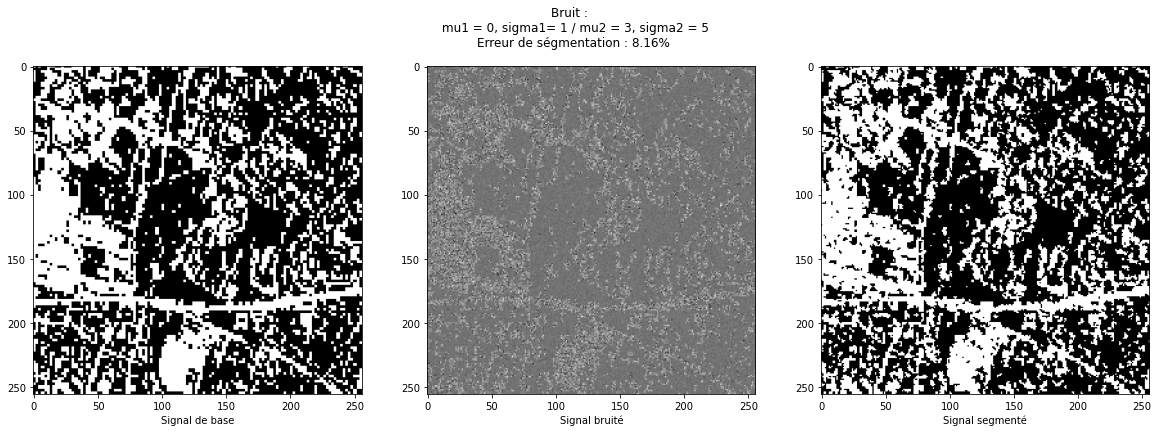

In [35]:
image_name = 'city2'

path = f'images/{image_name}.bmp'
image = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)

X = peano_transform_img(image)

class1, class2 = classes_calculations(X)

m1 = 0
sig1 = 1
m2 = 3
sig2 = 5

Y = bruit_gauss2(X, class1, class2, m1, sig1, m2, sig2)

S2, erreur = get_tau(Y, class1, class2, m1, sig1, m2, sig2)

fig, ax = plt.subplots(1, 3, figsize=(20, 6.5))
ax[0].imshow(transform_peano_in_img(X, 256), cmap='gray')
ax[1].imshow(transform_peano_in_img(Y, 256), cmap='gray')
ax[2].imshow(transform_peano_in_img(S2, 256), cmap='gray')

ax[0].set_xlabel("Signal de base")
ax[1].set_xlabel("Signal bruité")
ax[2].set_xlabel("Signal segmenté")

fig.suptitle("Bruit :  \n mu1 = {}, sigma1= {} / mu2 = {}, sigma2 = {}\nErreur de ségmentation : {:.2f}%".format(m1, sig1, m2, sig2, erreur*100))


### <ins>Question 8 :</ins>
> Tester la méthode pour les mêmes 3 images que la question 5 de la partie II, avec les 3 bruits du précédemment utilisés. Présenter les résultats (taux d’erreur et images segmentées) et commenter, en comparant les résultats avec ceux du modèle indépendant.

#### Functions

In [36]:
def plot_markov(X, class1, class2):
    Y = []
    S_l = []
    erreur_l = []

    for i in range(len(m1s)):
        Y.append(bruit_gauss2(X, class1, class2, m1s[i], sig1s[i], m2s[i], sig2s[i]))
        S, erreur = get_tau(Y[i], class1, class2 ,m1s[i], sig1s[i], m2s[i], sig2s[i])
        S_l.append(S)
        erreur_l.append(erreur)

    fig, ax = plt.subplots(3, 3, figsize=(12, 13))

    for i in range(len(m1s)):
        ax[i, 0].imshow(transform_peano_in_img(X, 256), cmap='gray')
        ax[i, 1].imshow(transform_peano_in_img(Y[i], 256), cmap='gray')
        ax[i, 2].imshow(transform_peano_in_img(S_l[i], 256), cmap='gray')

        ax[i, 0].set_xlabel("Signal de base")
        ax[i, 1].set_xlabel("Signal bruité")
        ax[i, 2].set_xlabel("Signal segmenté")

        ax[i, 0].set_xticks([]), ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([]), ax[i, 1].set_yticks([])
        ax[i, 2].set_xticks([]), ax[i, 2].set_yticks([])

        ax[i, 0].set_title("Bruit {}:".format(i+1) )
        ax[i, 1].set_title("mu1 = {} / sigma1 = {} // mu2 = {} / sigma2 = {}".format(
            i+1, m1s[i], sig1s[i], m2s[i], sig2s[i]) )
        ax[i, 2].set_title("Erreur de ségmentation : {:.2f}%".format(
            erreur_l[i]*100) )

        title = path.split('/')[1].split('.')[0]
        fig.suptitle("Image: {}".format(title))


#### Answer

In [37]:
images = [
    'cible2',
    'veau2',
    'city2'
]

m1s = [0, 1, 0]
m2s = [3, 1, 1]
sig1s = [1, 1, 1]
sig2s = [2, 5, 1]

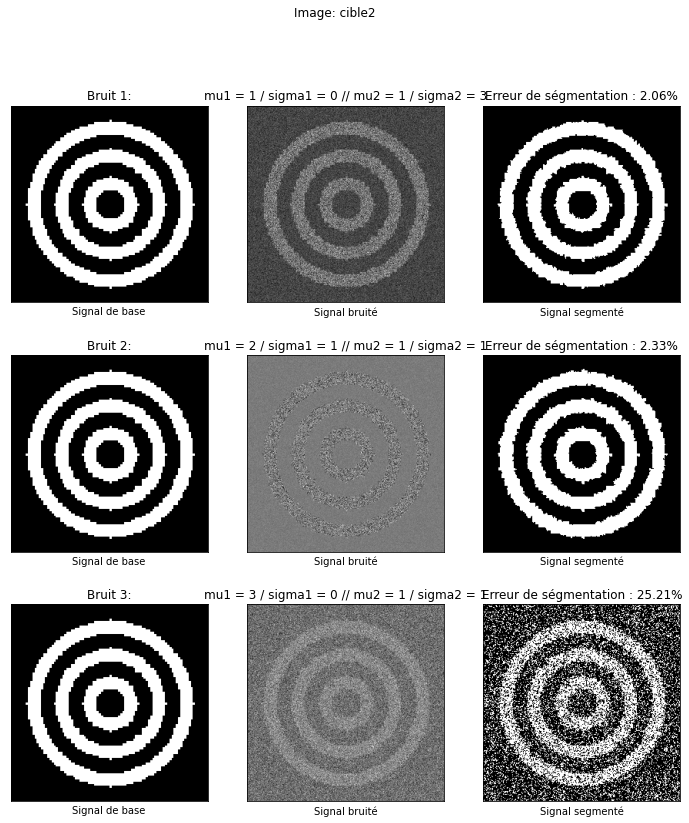

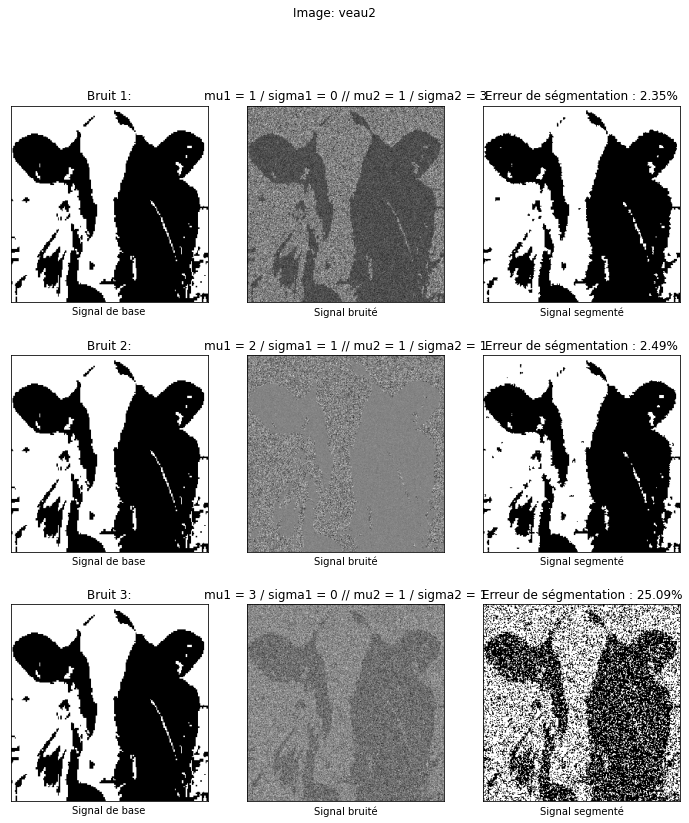

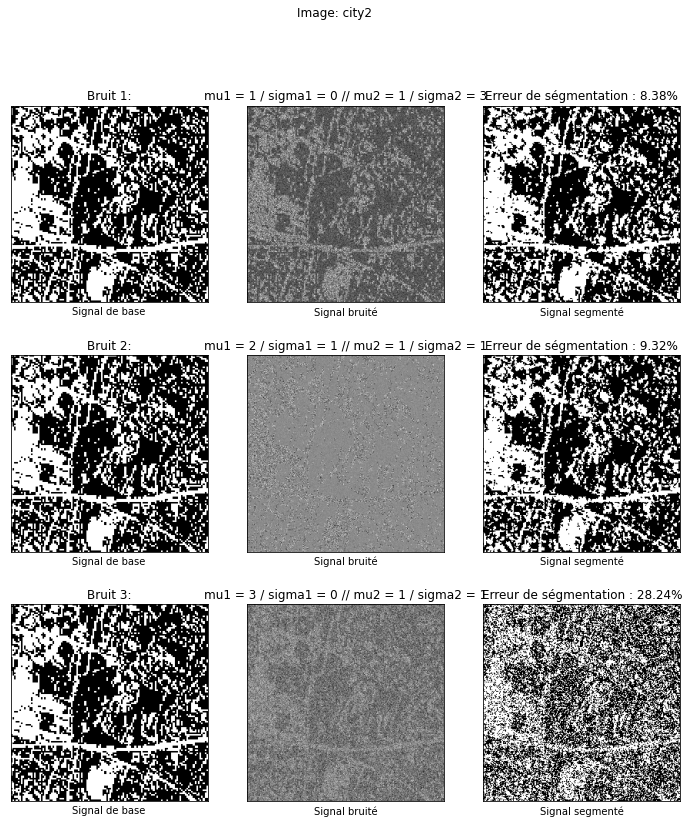

In [38]:
for image in images:

    path = f'images/{image}.bmp'

    X = peano_transform_img(cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY))

    class1, class2 = classes_calculations(X)

    plot_markov(X, class1, class2)


Avec ces derniers résultats nous observons les choses suivantes :

- Le taux d'erreur est moins important dans le Modèle de la chaine de Markov que dans le modèle indépendant donc, la chaine de Markov est meilleur pour reconstituer une image.

- Pour un même bruit, en utilisant le Modèle indépendant, contairement modèle de la chaine de Markov, les taux d'erreurs des différentes images sont assez proches. Nous pouvons expliquer cela puisque dans le premier modèle, nous considèrons que le motif de l'image ne suit aucune loi (purement aléatoire) et de ce fait toutes les images sont traitées identiquement alors que dans le deuxième on considère que chaque pixel dépend du précédent.

- La methode de Markov est plus efficace pour la premiere image, car la transition des pixels (noir vers blanc et viceversa) est moins importante.